In [176]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:86% !important;}
div.cell.code_cell.rendered{width:100%;}
div.CodeMirror {font-family:Consolas; font-size:15pt;}
div.output {font-size:15pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:15pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:15px;}
</style>
"""))

In [177]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical # 원핫인코딩
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from matplotlib import pyplot as plt # 학습과정 loss와 acc 시각화
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
# quiz에서는 scale 조정, train_test_split 등을 추가

- Red Wine 등급 예측
1. 데이터 셋 확보
    csv -> 결측치처리 -> 독립변수와 타겟변수 분리 -> 독립변수 스케일 조정,
    -> 타겟변수의 원핫인코딩 -> 훈련셋과 테스트셋 분리(train_test_split이용 층화추출)
2. 모델 구성(입력11, 출력 6 | 출력9) layer층 4
3. 모델 학습 과정 설정
4. 모델학습(callbacks이용)
5. 모델 평가(그래프, 평가, 교차표)
6. 모델저장 & 사용

# 1. 데이터 확보 & 전처리

In [178]:
# 데이터 읽어오기
# fixed acidity : 고정 산도
# volatile acidity : 휘발성 산도
# citric acid : 시트르산
# residual sugar : 잔류 당분
# chlorides : 염화물
# free sulfur dioxide : 자유 이산화황
# total sulfur dioxide : 총 이산화황
# density : 밀도
# pH
# sulphates : 황산염
# alcohol
# quality : 0 ~ 10(높을 수록 좋은 품질)
redwine = pd.read_csv('data/winequality-red.csv', sep=';')
print(redwine['quality'].value_counts())
X = redwine.iloc[:,:-1].values
y = redwine.iloc[:,-1].values
x_scaler = MinMaxScaler()
scaled_X = x_scaler.fit_transform(X)
scaled_X
y_data = to_categorical(y)
y_data[:2]

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64


array([[0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [179]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, 
                                                    y_data,
                                                    test_size=0.3,
                                                    random_state=3,
                                                    stratify=y_data
                                                   )
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1119, 11), (480, 11), (1119, 9), (480, 9))

# 2. 모델 구성

In [180]:
model = Sequential()
model.add(Dense(units=64,
               input_dim=11,
               activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=9, activation='softmax'))
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 64)                768       
                                                                 
 dense_46 (Dense)            (None, 32)                2080      
                                                                 
 dense_47 (Dense)            (None, 16)                528       
                                                                 
 dense_48 (Dense)            (None, 9)                 153       
                                                                 
Total params: 3,529
Trainable params: 3,529
Non-trainable params: 0
_________________________________________________________________


# 3. 모델 구성

In [181]:
model.compile(loss='categorical_crossentropy', # sparse_categorical_crossentropy -> 원핫인코딩 안할 경우 사용
             optimizer='nadam',
             metrics=['accuracy'])
earlystopping = EarlyStopping(monitor='val_accuracy',patience=30)

# 모델 자동 저장 콜백
import os
model_save_folder = './model09/'
if not os.path.exists(model_save_folder): # 폴더가 없으면 폴더 생성
    os.mkdir(model_save_folder)
file = model_save_folder + 'mnist-{epoch:03d}-val{val_accuracy:.4f}.h5'

checkpoint = ModelCheckpoint(filepath=file,
                            monitor='val_accuracy', # 모니터할 지표
                            save_best_only=True, # 모니터링 지표가 개선된 경우만 저장
                            mode = 'max', # 값이 클수록 저장
                            verbose=1 # 저장시 로그 출력
                            )

# 4. 모델 학습

In [182]:
%%time
hist = model.fit(X_train, y_train,
                epochs=100,
                validation_split=0.2, # 검증데이터를 훈련데이터의 20%로 사용
                verbose=1,
                callbacks=[earlystopping, checkpoint])

Epoch 1/100
 1/28 [>.............................] - ETA: 18s - loss: 2.1736 - accuracy: 0.0625
Epoch 1: val_accuracy improved from -inf to 0.36607, saving model to ./model09\mnist-001-val0.3661.h5
28/28 [==============================] - 1s 8ms/step - loss: 1.9199 - accuracy: 0.3553 - val_loss: 1.6079 - val_accuracy: 0.3661
Epoch 2/100
 1/28 [>.............................] - ETA: 0s - loss: 1.6516 - accuracy: 0.5000
Epoch 2: val_accuracy improved from 0.36607 to 0.57143, saving model to ./model09\mnist-002-val0.5714.h5
28/28 [==============================] - 0s 4ms/step - loss: 1.3450 - accuracy: 0.4369 - val_loss: 1.2697 - val_accuracy: 0.5714
Epoch 3/100
28/28 [==============================] - ETA: 0s - loss: 1.1986 - accuracy: 0.5173
Epoch 3: val_accuracy did not improve from 0.57143
28/28 [==============================] - 0s 3ms/step - loss: 1.1986 - accuracy: 0.5173 - val_loss: 1.2181 - val_accuracy: 0.5670
Epoch 4/100
 1/28 [>.............................] - ETA: 0s - loss: 

 1/28 [>.............................] - ETA: 0s - loss: 1.4053 - accuracy: 0.4688
Epoch 29: val_accuracy did not improve from 0.62500
28/28 [==============================] - 0s 3ms/step - loss: 0.9242 - accuracy: 0.6179 - val_loss: 0.9499 - val_accuracy: 0.6071
Epoch 30/100
 1/28 [>.............................] - ETA: 0s - loss: 0.9777 - accuracy: 0.5312
Epoch 30: val_accuracy did not improve from 0.62500
28/28 [==============================] - 0s 3ms/step - loss: 0.9234 - accuracy: 0.6179 - val_loss: 0.9541 - val_accuracy: 0.6116
Epoch 31/100
 1/28 [>.............................] - ETA: 0s - loss: 0.7369 - accuracy: 0.7188
Epoch 31: val_accuracy did not improve from 0.62500
28/28 [==============================] - 0s 3ms/step - loss: 0.9206 - accuracy: 0.6056 - val_loss: 0.9420 - val_accuracy: 0.6161
Epoch 32/100
 1/28 [>.............................] - ETA: 0s - loss: 0.9429 - accuracy: 0.5625
Epoch 32: val_accuracy did not improve from 0.62500
28/28 [===========================

28/28 [==============================] - 0s 3ms/step - loss: 0.8702 - accuracy: 0.6413 - val_loss: 0.9393 - val_accuracy: 0.6250
Epoch 59/100
24/28 [========================>.....] - ETA: 0s - loss: 0.8867 - accuracy: 0.6224
Epoch 59: val_accuracy did not improve from 0.62946
28/28 [==============================] - 0s 4ms/step - loss: 0.8720 - accuracy: 0.6302 - val_loss: 0.9331 - val_accuracy: 0.6295
Epoch 60/100
 1/28 [>.............................] - ETA: 0s - loss: 0.6384 - accuracy: 0.8125
Epoch 60: val_accuracy did not improve from 0.62946
28/28 [==============================] - 0s 3ms/step - loss: 0.8694 - accuracy: 0.6212 - val_loss: 0.9544 - val_accuracy: 0.6161
Epoch 61/100
 1/28 [>.............................] - ETA: 0s - loss: 0.5939 - accuracy: 0.7500
Epoch 61: val_accuracy did not improve from 0.62946
28/28 [==============================] - 0s 3ms/step - loss: 0.8713 - accuracy: 0.6291 - val_loss: 0.9442 - val_accuracy: 0.6250
Epoch 62/100
 1/28 [>...................

In [183]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

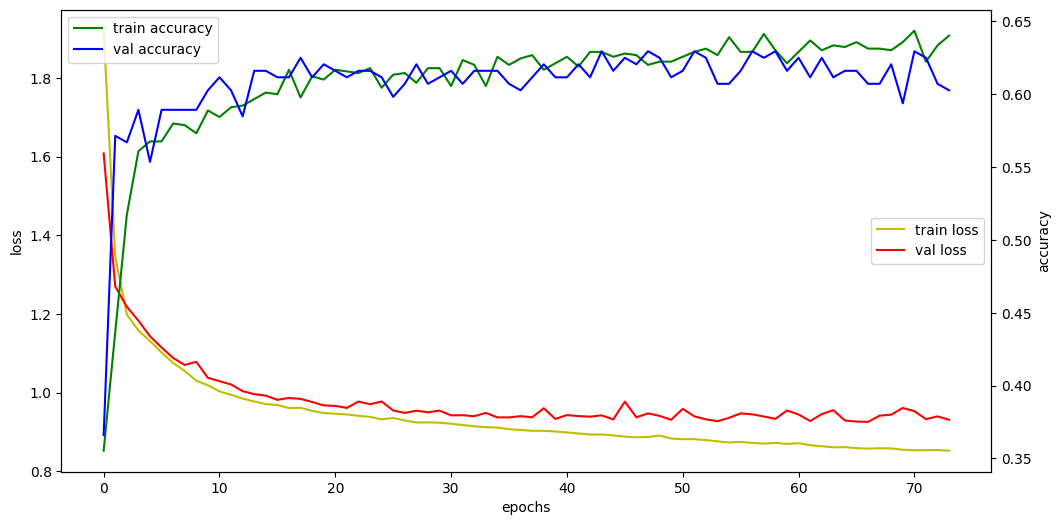

In [184]:
fig, loss_ax = plt.subplots(figsize=(12,6))
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val accuracy')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend()
plt.show()

In [185]:
# 모델 평가하기
loss_and_metrics = model.evaluate(X_test, y_test, batch_size=100, verbose=1)
print('loss :', loss_and_metrics[0])
print('accuracy :', loss_and_metrics[1])

5/5 [==============================] - 0s 2ms/step - loss: 0.9318 - accuracy: 0.6083
loss : 0.9317783117294312
accuracy : 0.6083333492279053


In [186]:
# 모델 저장
model.save('model/09_mnist.h5')

In [ ]:
loss_and_metrics2 = model